<a href="https://colab.research.google.com/github/sthirug/aiml/blob/main/Generic_Ngram_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This is a generic N-Gram using Neural Network and One Hot Encoding

# 0. Configurations

In [ ]:
import torch
import os
import matplotlib.pyplot as plt
import random
import numpy as np

In [ ]:
# CONFIGURATIONS

# N-Gram
ngram_size = 3
input_size = ngram_size - 1

# Random seed value
seed = 2147483647

# Random Generator
g = torch.Generator()
g.manual_seed(seed)

# Dataset splits
train = 0.7
dev = 0.1
test = 0.2

# Hyperparameters
batch_sz = 128 #5#128
lr = 30
epocs = 2

# Source file
name_files = {"English":"/content/drive/MyDrive/Colab Notebooks/DL Experiments/names.txt","Indian":"/content/drive/MyDrive/Colab Notebooks/DL Experiments/IndianNames.txt"}

name_file = name_files.get("Indian")

# 1. Data preparation

In [ ]:
# Data preperations | Get all names into a list
all_names = open(name_file,'r').read().lower()

spl_chars = ['.', ' ','-']
for s in spl_chars:
  all_names = all_names.replace(s, '')

names = all_names.splitlines()
len(names)

55691

In [ ]:
# Build the vocabulary of characters with '.' denoting start or end of a word
vocab = ['.'] + sorted(set(''.join(names)))
l=len(vocab)

# Assign lookups for Vocab to integer and Integer to Vocab
vtoi = {c:i for i,c in enumerate(vocab)}
itov = {i:c for i,c in enumerate(vocab)}
prefix = ''.join(['.' for _ in range(input_size)])

In [ ]:
# #spot check
# print(prefix)

# tp = [l for _ in range(ngram_size)]
# dim_size = tuple(tp)
# dim_size

In [ ]:
# Build the dataset of Xs and Ys
full_ds = []

for n in names:
  n = prefix + n + '.'
  #print(n)
  for i in range(len(n) - input_size):
    t = n[i:i+ngram_size]
    full_ds.append([t[:input_size], t[input_size:]])

full_ds_len = len(full_ds)

In [ ]:
# batch_size = len(full_ds)

In [ ]:
xsenc_base_ds = torch.zeros((full_ds_len, input_size, l))

for b in range(full_ds_len):
  input = list(full_ds[b][0])
  #print(input) 
  for i in range(input_size):
    c = input[i]
    x = vtoi.get(c)
    xenc = torch.nn.functional.one_hot(torch.tensor(x), num_classes=l).float()
    xsenc_base_ds[b,i] += xenc

xsenc_flat_ds = xsenc_base_ds.view(full_ds_len,-1)
xsenc_flat_ds.shape

torch.Size([505457, 54])

In [ ]:
# # Spot check if encoding is done properly
# n = 10
# plt.figure(figsize=(12, 8))
# plt.imshow(xsenc_flat[:n],  aspect='auto')
# plt.xlabel('Charactor(Uchars) index')
# plt.ylabel('Example # from Batch')
# plt.grid(axis='both')
# plt.xticks(np.arange(0, l), labels=np.arange(0, l))
# plt.yticks(np.arange(0, n), labels=np.arange(0, n))
# plt.show()

# print(dataset[:n])

In [ ]:
ys = [vtoi.get(e[1]) for e in full_ds]

# Part 2 (Optimization with full batch GD and not using a class/Dev/Train/Test split)

In [ ]:
# rng = list(range(len(full_ds)))
# #print(rng[:10])
# random.shuffle(rng)
# #print(rng[:10])

# batch_count = int(full_ds_len/batch_sz)
# batch_count

In [ ]:
# idx1 = int(train*full_ds_len)
# idx2 = int((train+dev)*full_ds_len)

# train_ds = full_ds[:idx1]
# dev_ds = full_ds[idx1:idx2]
# test_ds = full_ds[idx2:]

# # print(full_ds_len)
# # print(len(train_ds))
# # print(len(dev_ds))
# # print(len(test_ds))

In [ ]:
nin = l * input_size
nout = l
print(nin, nout)

# Initialize weights
W = torch.randn((nin, nout), requires_grad=True, generator=g)

54 27


In [ ]:
# Initialize loss history and run number
loss_hist = []
run_no = 1

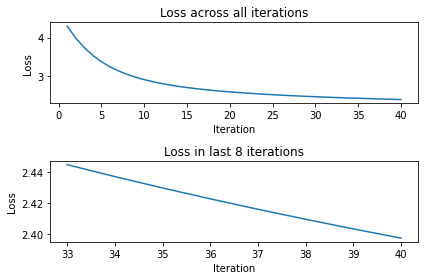

[[10, 40, 2.3975472450256348]]

In [ ]:
batch_sz = len(ys)
# Training

# Override learning rate
lr = 10
itr = 10

for i in range(itr):
  # Forward pass
  logits = xsenc_flat_ds @ W  # For BiGram => b X 27 @ 27 X 27 = b X 27
  counts = torch.exp(logits) # For BiGram => b X 27
  probs = counts/counts.sum(dim = 1, keepdim = True) # For BiGram => b X 27

  # Calculate loss
  ixes = list(range(batch_sz))
  loss = -torch.log(probs[ixes, ys]).mean()

  loss_hist.append([lr,run_no,loss.item()])
  run_no += 1

  # Backward pass
  W.grad = None
  loss.backward()

  # Update gradients in the opposite direction of the gradient
  W.data += lr * -W.grad

# Display the loss
plot_data = loss_hist[::-1]
total = len(plot_data)
recent = int(0.20 * total)
x1 = [row[1] for row in plot_data]
y1 = [row[2] for row in plot_data]
x2 = [row[1] for row in plot_data[:recent]]
y2 = [row[2] for row in plot_data[:recent]]

#Entire loss curve
plt.subplot(2,1,1)
plt.plot(x1, y1)
plt.title('Loss across all iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')

#recent loss curve in last 10% of iterations
plt.subplot(2,1,2)
plt.plot(x2, y2)
plt.title('Loss in last {} iterations'.format(recent))
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

loss_hist[::-1][:(1)]

In [ ]:
# ## Inference - Generate new names :)

# for i in range(20):
#   ix = torch.tensor([0])

#   pred = ''
#   while True:
#     xenc = torch.nn.functional.one_hot(ix, num_classes=l).float()
#     logits = xenc @ W
#     cts = torch.exp(logits)
#     probx = cts/cts.sum(dim=1, keepdim=True)
#     ix = torch.multinomial(probx.view(l), 1, replacement=True, generator=g)

#     if ix.item() == 0:
#       # if pred.strip() == '':
#       #   print(ix)
#       #   print(prob)
#       #   print(counts)
#       break

#     pred += itov.get(ix.item())

#   print(pred)

In [ ]:
loss_hist[::-1][:30]

[[10, 40, 2.3975472450256348],
 [10, 39, 2.403494119644165],
 [10, 38, 2.409675121307373],
 [10, 37, 2.416107416152954],
 [10, 36, 2.42280912399292],
 [10, 35, 2.4298009872436523],
 [10, 34, 2.437105655670166],
 [10, 33, 2.4447500705718994],
 [10, 32, 2.4527618885040283],
 [10, 31, 2.4611732959747314],
 [10, 30, 2.470021963119507],
 [10, 29, 2.4793479442596436],
 [10, 28, 2.4891984462738037],
 [10, 27, 2.4996252059936523],
 [10, 26, 2.510688543319702],
 [10, 25, 2.522458076477051],
 [10, 24, 2.535012722015381],
 [10, 23, 2.548445463180542],
 [10, 22, 2.5628678798675537],
 [10, 21, 2.578411817550659],
 [10, 20, 2.5952389240264893],
 [10, 19, 2.6135458946228027],
 [10, 18, 2.6335768699645996],
 [10, 17, 2.6556336879730225],
 [10, 16, 2.6800906658172607],
 [10, 15, 2.707411766052246],
 [10, 14, 2.7381696701049805],
 [10, 13, 2.7730700969696045],
 [10, 12, 2.8129849433898926],
 [10, 11, 2.8589892387390137]]

In [ ]:
## Inference - Generate new names :)

print("***** Prediction of {} names *****".format(next((k for k, v in name_files.items() if v == name_file), None)))
print('')

nid = 0
nop = 10

for i in range(nop):
  ixes = torch.zeros((input_size), dtype = torch.int64)

  pred = ''
  while True:
    # print(i, ixes)

    encoded = []
    for ix in ixes:
      a = torch.nn.functional.one_hot(ix, num_classes=l).float()
      encoded += a.tolist()
    xenc = torch.tensor(encoded).view(1,-1)

    logits = xenc @ W
    cts = torch.exp(logits)
    probx = cts/cts.sum(dim=1, keepdim=True)
    ix = torch.multinomial(probx.view(l), 1, replacement=True, generator=g)

    if ix.item() == 0:
      break

    ixes = torch.cat((ixes[1:],ix))
    pred += itov.get(ix.item())

  if pred in names:
    pred += ' *** IN TRAINING SET********************'
    nid += 1

  print(pred)

print('')
print(f'{nid*100/nop}% found in training set')

***** Prediction of Indian names *****

n
vei
mbjharensofkbqma
vabhganva
mith
ankaviqarinahrliee
sugmkkdha
mahaan *** IN TRAINING SET********************
liuhan
koqobhanisha

10.0% found in training set


# Part 2 (Optimization with class and mini-batch GD) | No regularization yet

In [ ]:
class Layer:
  def __init__(self, no_of_inputs, no_of_outputs):
    self.nin = no_of_inputs
    self.nout = no_of_outputs

In [ ]:
class Nnetwork:
  def __init__(self, layers, xs, ys, train_split, dev_split, bsize, lr, epoch, generator, rl = 0.):

    # Set all the instance variables
    self._weights = []

    self._layers = layers
    self._nol = len(layers)

    self._xs = xs
    self._ys = ys
    self._ds_len = len(xs)

    self._train_split = train_split
    self._dev_split = dev_split
    self._test_split = 1. - self._train_split - self._dev_split

    self._bsize = bsize
    self._lr = lr

    self._g = generator
    self._rl = rl

    self.ctr = 0
    # Call the initialization methods
    self.reset_hist()
    self.split_data() # Train, Dev and Test split
    #self.xs_b, self.ys_b = self.split_batches(self._train_xs, self._train_ys, self._bsize)
    self.initialize_weights()

  def __str__(self):
    return '_nol: {} | xs_len: {} | ys_len {} | train_split {} | dev split {} | test split: {} | batch size: {} | lr: {} | train size: {}'.format(self._nol, len(self._xs), len(self._ys), self._train_split, self._dev_split, self._test_split, self._bsize, self._lr, len(self._train_xs))

  def initialize_weights(self):
    for l in self._layers:
      _current_weight = torch.randn((l.nin,l.nout), requires_grad=True, generator=self._g)
      self._weights.append(_current_weight)

  def split_data(self):
    i = list(range(self._ds_len))
    random.shuffle(i)

    idx1 = int(self._train_split*self._ds_len)
    idx2 = int((self._train_split+self._dev_split)*self._ds_len)

    self._train_xs = self._xs[:idx1]
    self._dev_xs = self._xs[idx1:idx2]
    self._test_xs = self._xs[idx2:]

    self._train_ys = self._ys[:idx1]
    self._dev_ys = self._ys[idx1:idx2]
    self._test_ys = self._ys[idx2:]

  def split_batches(self, xs, ys, bsize):
    l = len(xs)
    no_of_batches = int(l/bsize)
    ixes = list(range(l))
    random.shuffle(ixes)

    xs_batches = [xs[ixes[i*bsize:(i*bsize+bsize)]] for i in range(no_of_batches)]
    ys_batches = [ys[ixes[i*bsize:(i*bsize+bsize)]] for i in range(no_of_batches)]

    return xs_batches, ys_batches

  def forward_pass_and_loss(self, xs, ys, regularize = True):
    bs = len(xs)
    W = self._weights[0]

    # Forward pass
    logits = xs @ W
    counts = torch.exp(logits)
    probs = counts/counts.sum(dim = 1, keepdim = True)

    # Calculate loss
    ixes = list(range(bs))
    loss = -torch.log(probs[ixes, ys]).mean() 
    
    if regularize == True:
      loss += self._rl * (W**2).mean()

    return loss

  def backward_pass(self, loss):
    for w in self._weights:
      w.grad = None   
    loss.backward()

  def update_gradients(self):
    for w in self._weights:
      w.data += self._lr * -w.grad    

  def train(self, xs_b, ys_b):
    train_loss = (self.forward_pass_and_loss(self._train_xs, self._train_ys)).item()
    dev_loss = (self.forward_pass_and_loss(self._dev_xs, self._dev_ys, False)).item()
    self._train_dev_loss_hist.append([self._epoch_no, train_loss, dev_loss])

    self._epoch_no += 1
    xs_b, ys_b = self.split_batches(xs_b, ys_b, self._bsize)

    for xs, ys in zip(xs_b, ys_b):
      loss = self.forward_pass_and_loss(xs, ys)
      self.backward_pass(loss)
      self.update_gradients()
      self.add_fp_stats(loss.item())
    # print(self._loss_hist[::-1][:(1)])

  
  def add_fp_stats(self, loss):
    self._run_no += 1
    self._loss_hist.append([self._lr, self._run_no,  loss])
    # print(f'{train_loss=} {dev_loss=}')
 
  def reset_hist(self):
    self._run_no = 0
    self._epoch_no = 0
    self._loss_hist = []
    self._train_dev_loss_hist = []

  def plot_mini_batch_loss(self, loss_history):
    # Display the loss
    plot_data = loss_history[::-1]
    total = len(plot_data)
    recent = int(0.20 * total)
    x1 = [row[1] for row in plot_data]
    y1 = [row[2] for row in plot_data]
    x2 = [row[1] for row in plot_data[:recent]]
    y2 = [row[2] for row in plot_data[:recent]]

    #Entire loss curve
    plt.subplot(2,1,1)
    plt.plot(x1, y1)
    plt.title('Loss across all iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')

    #recent loss curve in last 10% of iterations
    plt.subplot(2,1,2)
    plt.plot(x2, y2)
    plt.title('Loss in last {} iterations'.format(recent))
    plt.xlabel('Iteration')
    plt.ylabel('Loss')

    plt.tight_layout()
    plt.show()

    print(loss_history[::-1][:(1)])

  def plot_train_vs_dev(self, train_dev_loss):
    plot_data = train_dev_loss

    x = [row[0] for row in plot_data]
    ytrain = [row[1] for row in plot_data]
    ydev = [row[2] for row in plot_data]

    plt.plot(x, ytrain, label ='Train')
    plt.plot(x, ydev, '-.', label ='Dev')

    plt.xlabel("Epoch data")
    plt.ylabel("Loss data")
    plt.legend()
    plt.title('Train and Dev losses')
    plt.show()

  def make_pred(self):
    ## Inference - Generate new names :)

    print("***** Prediction of {} names *****".format(next((k for k, v in name_files.items() if v == name_file), None)))
    print('')

    nid = 0
    nop = 10

    for i in range(nop):
      ixes = torch.zeros((input_size), dtype = torch.int64)

      pred = ''
      while True:
        # print(i, ixes)

        encoded = []
        for ix in ixes:
          a = torch.nn.functional.one_hot(ix, num_classes=l).float()
          encoded += a.tolist()
        xenc = torch.tensor(encoded).view(1,-1)

        W = self._weights[0]

        logits = xenc @ W
        cts = torch.exp(logits)
        probx = cts/cts.sum(dim=1, keepdim=True)
        ix = torch.multinomial(probx.view(l), 1, replacement=True, generator=g)

        if ix.item() == 0:
          break

        ixes = torch.cat((ixes[1:],ix))
        pred += itov.get(ix.item())

      if pred in names:
        pred += ' *** IN TRAINING SET********************'
        nid += 1

      print(pred)

    print('')
    print(f'{nid*100/nop}% found in training set')

In [ ]:
t = 0.8
d = 0.1
lr = 5
rl = 0.01

nin = l * input_size
nout = l
print(nin, nout)

l1 = Layer(nin,nout)
#l2 = Layer(5,3)
layers = [l1]

# nn = Nnetwork(layers = layers, xs = xsenc_flat_ds[:10], ys = torch.tensor(ys[:10]), train_split = 0.8, dev_split = 0.1, bsize = 6, lr = 10, epoch=3, generator=g)
nn = Nnetwork(layers = layers, xs = xsenc_flat_ds, ys = torch.tensor(ys), train_split = t, dev_split = d, bsize = 128, lr = lr, epoch=3, generator=g, rl = rl)

54 27


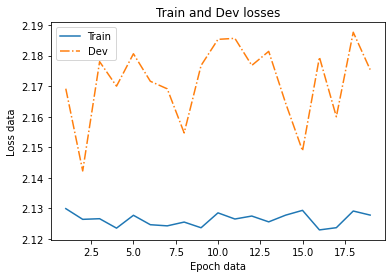

In [ ]:
nn._lr = 5 #10
nn._rl = 0.01

for i in range(10):
  nn.train(nn._train_xs, nn._train_ys)

nn.plot_train_vs_dev(nn._train_dev_loss_hist[1:])

In [ ]:
test_loss = (nn.forward_pass_and_loss(nn._test_xs, nn._test_ys)).item()
full_loss = (nn.forward_pass_and_loss(nn._xs, nn._ys)).item()
print(f'{test_loss=} {full_loss=}')

test_loss=2.1898412704467773 full_loss=2.136319637298584


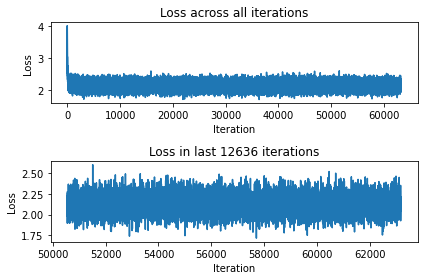

[[5, 63180, 2.0498433113098145]]


In [ ]:
nn.plot_mini_batch_loss(nn._loss_hist)

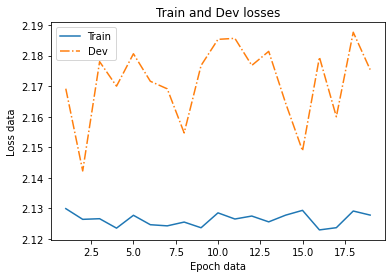

[[0, 3.9817862510681152, 3.945720911026001],
 [1, 2.129953145980835, 2.169173240661621],
 [2, 2.126447916030884, 2.142277956008911],
 [3, 2.126657485961914, 2.178006887435913],
 [4, 2.1235735416412354, 2.1700077056884766],
 [5, 2.1277735233306885, 2.180600881576538],
 [6, 2.1246938705444336, 2.171602249145508],
 [7, 2.1243185997009277, 2.169128179550171],
 [8, 2.1255574226379395, 2.154714345932007],
 [9, 2.1236965656280518, 2.176758289337158],
 [10, 2.1285691261291504, 2.1853113174438477],
 [11, 2.1265571117401123, 2.1856348514556885],
 [12, 2.127528429031372, 2.1767847537994385],
 [13, 2.1256263256073, 2.1813805103302],
 [14, 2.127817392349243, 2.164466142654419],
 [15, 2.129385471343994, 2.1488614082336426],
 [16, 2.1229910850524902, 2.1794774532318115],
 [17, 2.1237196922302246, 2.1599957942962646],
 [18, 2.1291685104370117, 2.187633752822876],
 [19, 2.1278374195098877, 2.175415515899658]]

In [ ]:
nn.plot_train_vs_dev(nn._train_dev_loss_hist[1:])
nn._train_dev_loss_hist

In [ ]:
nn.make_pred()

***** Prediction of Indian names *****

shi
jararsha
tarnyan
thanotanayahindhanikaleh
cadhwarrshwaprakritap
bren
nackor
ilangan
hmin
maleveethyan

0.0% found in training set
